In [1]:
# import python library
import tensorflow as tf
import keras
import numpy as np
import cv2 
import matplotlib.pyplot as plt
# configure and test
tf.test.gpu_device_name()
% matplotlib inline

Using TensorFlow backend.


In [2]:
a = tf.constant([[1, 2,3],[1, 2,3]], dtype = tf.float32)
a.get_shape().as_list()[1]
shape = [5, 5, 3, 32]
print(shape[3])

32


In [3]:
# define the neural network architecture 
# define needed variables during training 
from keras.layers import Dense, Conv2D, Flatten, BatchNormalization
def _variable_summaries(var):
    """
    Attach a lot of summaries to a Tensor (for TensorBoard visualization).
    """
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
            tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)
    
class model(object):
    # class level attributes, used for 
    number = 0
    def __init__(self, name):
        model.name = name
    # finally build our model according to our own need
    def builder(self, x, y):
        self.conv1 = self._conv_layer(x,     [5, 5, 3, 32],  'conv1')
        self.conv2 = self._conv_layer(self.conv1, [3, 3, 32, 64], 'conv2')
        self.pool1 = self._max_pool22(self.conv2)
        # ffnet1
        self.ffn1  = self._ffnet_module(self.pool1,f = [3, 5], filters = [64, 64, 64, 64] , stage = 1, block = 'a')
        self.ffn2  = self._ffnet_module(self.ffn1 ,f = [3, 5], filters = [64, 64, 64, 64],  stage = 2, block = 'a' )
        self.fc1   = self._fc_layer(tf.reshape(self.ffn2, [-1, 8*8*128]), 8*8*128, 256, 'fc1' )
        self.fc2   = self._fc_layer(self.fc1, 256, 10, 'fc2')
        self.y_    = tf.nn.softmax(self._fc_layer(self.fc2, 10, 2, 'fc2'), name='output')
        #self.merged = tf.summary.merge_all()
    # class methods to construct conv-layer, generating summary autotically 
    # with default stride 1, and relu activations
    def _conv_layer(self, X, shape, layer_name, padding='SAME'):
        with tf.name_scope(layer_name):
            with tf.name_scope('W'):
                weight = self.get_filters(shape)
                _variable_summaries(weight)
            with tf.name_scope('b'):
                #print(shape[3])
                bias = self.get_bias([shape[3]])
                print(shape[3])
                _variable_summaries(bias)
            with tf.name_scope('z'):
                preactivations = tf.nn.conv2d(X, weight, strides=[1, 1, 1, 1], padding=padding) + bias
                _variable_summaries(preactivations)
            with tf.name_scope('A'):
                activations    = tf.nn.relu(preactivations)
                _variable_summaries(activations)
        return activations
    
    # ex: prob = tf.constant(0.5, dtype=tf.float32)
    def _drop_out(self, X, prob, layer_name):
        with tf.name_scope(layer_name+'Dropout'):
            return tf.nn.dropout(X, prob)
    def _max_pool22(self, X, padding = 'SAME'):
        return tf.nn.max_pool(X, strides= [1, 2, 2, 1], ksize=[1, 2, 2, 1], padding= padding)
           
    def _fc_layer(self, X, input_dim, output_dim, layer_name, act=tf.nn.relu):
        with tf.name_scope(layer_name):
      # This Variable will hold the state of the weights for the layer
            with tf.name_scope('W'):
                weights = self.get_weights([input_dim, output_dim])
                _variable_summaries(weights)
            with tf.name_scope('b'):
                biases = self.get_bias([output_dim])
                _variable_summaries(biases)
            with tf.name_scope('z'):
                preactivate = tf.matmul(X, weights) + biases
                tf.summary.histogram('pre_activations', preactivate)
            activations = act(preactivate, name='activation')
            tf.summary.histogram('activations', activations)
        return activations

    def _ffnet_module(self, X, f, filters, stage, block):
        """
        Implementation of the figure above, with 3 standard 3*3*64 module for the general module, and one fast-forwarding path
        Arguments: 
        X--      the input tensor with shape (n_H, n_W, n_C)
        f--      filter kernel size
        filters: number of filters in each layer
        stage  : name of stage 
        block  : string/character, used to name the layers, depending on 

        Returns:
        X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
        """
        conv_name_base = 'ffnet' + str(stage) + block + 'conv_branch'
        bn_name_base   = 'bn' + str(stage) + block + 'bn_branch'
        fast_fwd_base  = 'ffnet' + str(stage) + block + 'fast_branch' 

        # Retrieve filters 
        F1, F2, F3, F4 = filters
        f1, f2     = f
        m = X.get_shape().as_list()[3]

        # Save the input value
        X_fast = X

        ####### Main Path ######
        X = self._conv_layer(X, [f1, f1, m, F1],  layer_name = conv_name_base + '1', padding = 'VALID')
        setattr(self, 'ffnet'+str(stage)+'_1', X)
        X = self._conv_layer(X, [f1, f1, F1, F2], layer_name = conv_name_base + '2', padding = 'VALID')
        setattr(self, 'ffnet'+str(stage)+'_2', X)
        X = self._conv_layer(X, [f1, f1, F2, F3], layer_name = conv_name_base + '3', padding = 'SAME')
        ####### fast forward ###### 
        X_fast = self._conv_layer(X_fast, [f2, f2, m, F4], layer_name = fast_fwd_base + '1', padding = 'VALID')
        setattr(self, 'ffnet'+str(stage)+'_4', X_fast)
        print(X_fast)
        print(X)
        result = tf.concat([X, X_fast], 3) 
        print(result)
        ###### Final step: concatation #######

        return result
        
    def get_filters(self, shape):
        initial = tf.truncated_normal(shape, stddev=0.1)
        return(tf.Variable(initial))
    
    def get_weights(self, shape):
        initial = tf.truncated_normal(shape, stddev=0.1)
        return(tf.Variable(initial))
    
    def get_bias(self, output_dim):
        initial = tf.constant(0.1, shape = output_dim)
        return tf.Variable(initial)

In [4]:
# encoding the labels information
def label_encoder(labels, C, style = 'one_hot_matrix'):
    """
    Creates a matrix where the i-th row corresponds to the ith class number and the jth column
                     corresponds to the jth training example. So if example j had a label i. Then entry (i,j) 
                     will be 1. 
                     
    Arguments:
    
    labels -- vector containing the labels 
    C -- number of classes, the depth of the one hot dimension
    
    Returns: 
    encoded labels in a pattern of matrix
    one_hot -- one hot matrix
    """
    
    ### START CODE HERE ###
    if style is 'one_hot_matrix':
        # Create a tf.constant equal to C (depth), name it 'C'. (approx. 1 line)
        C = tf.constant(C, name='C')

        # Use tf.one_hot, be careful with the axis (approx. 1 line)
        one_hot_matrix = tf.one_hot(indices=labels, depth=C, axis=0)

        # Create the session (approx. 1 line)
        sess = tf.Session()

        # Run the session (approx. 1 line)
        label_encoded = sess.run(one_hot_matrix)

        # Close the session (approx. 1 line). See method 1 above.
        sess.close()
    
    ### END CODE HERE ###
    
    return label_encoded

# Using TFrecorder to store and read data
#### 1. List images and their label 
#### 2. Create a TFRecord file
-   Define function to load images and convert data into features
-   Open a TFrecord file 
-   Create a feature and pass the converted data into it
-   Create an example protocol
-   Serialize the example 
-   Write the example to TFRecord file

#### 3. Read the TFRecord file 
- Create a list of filenames
- Create a queue to hold filenames 
- Define a reader
- Define a decoder 
- Convert the data from string back to numbers 
- Reshape data into its original shape
- Preprocessing
- batching 

In [5]:
pwd

'/home/dragonx/Documents/text_detect'

In [6]:
from random import shuffle 
import glob
shuffle_data  = True # whether we will need to shuffle the filenames 
txt_patch1    = './dataC/COCO-Text-Patch/images/txt/*.jpg'
txt_patch2    = './dataA/COCO-Text-Patch/images/txt/*.jpg'
nontxt_patch1 = './dataC/COCO-Text-Patch/images/nontxt/*.jpg'
nontxt_patch2 = './dataA/COCO-Text-Patch/images/nontxt/*.jpg'
addrs_txt  = glob.glob(txt_patch1) + glob.glob(txt_patch2)
labels_txt = [0 for addr in addrs_txt]
addrs_nontxt  = glob.glob(nontxt_patch1) + glob.glob(nontxt_patch2)
labels_nontxt = [1 for addr in addrs_nontxt]
labels = labels_txt + labels_nontxt
addrs  = addrs_txt + addrs_nontxt
if shuffle_data:
    c = list(zip(addrs, labels))
    shuffle(c)
    addrs, labels = zip(*c)
# test module assert len(labels_txt)
print('we have %d txt instances, and %d nontxt instances'%(len(labels_txt),len(labels_nontxt)))
print('with %d images in total'%(len(labels)))
# print(','.join([str(x) for x in labels[0:100]]))
# print('[%s]'%', '.join(map(str, labels[0:100])))
# print(' '.join(['{:01d}'.format(x) for x in labels[0:100]]))
# divide dataset into train, dev, test with 70 20 10%
train_addrs = addrs[0:int(0.7*len(addrs))]
train_labels = labels[0:int(0.7* len(labels))]

dev_addrs = addrs[int(0.7*len(addrs)):int(0.9*len(addrs))]
dev_labels = labels[int(0.7*len(labels)):int(0.9*len(labels))]

test_addrs = addrs[int(0.9*len(addrs)):len(addrs)]
test_labels = labels[int(0.9*len(labels)):len(labels)]
print('divided into train: %d , val: %d test: %d  images'%(int(0.7*len(addrs)), int(0.2*len(addrs)), int(0.1*len(addrs)) ))

we have 106748 txt instances, and 123588 nontxt instances
with 230336 images in total
divided into train: 161235 , val: 46067 test: 23033  images


In [15]:
# function to load images
# print
# Features 
import sys
def load_image(addr):
    # read image and keep the size (32, 32, 3) currently 
    img = cv2.imread(addr)
    #img = cvb2.resize(img, (180, 180), interpolation= cv2.INTER_CUBIC)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)
    
    return img
# function to convert data into features
def _int64_feature(value):
    return tf.train.Feature(int64_list = tf.train.Int64List(value = [value]))

def _bytes_feature(value):
    return tf.train.Feature(bytes_list = tf.train.BytesList(value = [value]))

###########so now let's start to build our TFRecord object############
train_filename = 'train.tfrecords'
writer         =tf.python_io.TFRecordWriter(train_filename)
for i in range(len(train_addrs)):
    # saving every 1000 images and print how many batches 
    if not i%1000:
        print('Train data: {}/{}'.format(i, len(train_addrs)))
        sys.stdout.flush()
    # where we load the image
    img = load_image(train_addrs[i])
    label = train_labels[i]
    # now we transform the data into features in TFRecord data, reduce the file size into binary files
    feature = {'dataset/label': _int64_feature(label),
               'dataset/data' : _bytes_feature(tf.compat.as_bytes(img.tostring())) }
    # Example of format to write data into a TFRecord object
    example = tf.train.Example(features = tf.train.Features(feature = feature))
    # finally we wil write the data into file sequentially 
    writer.write(example.SerializeToString())
    
writer.close()
sys.stdout.flush()

Train data: 0/161235
Train data: 1000/161235
Train data: 2000/161235
Train data: 3000/161235
Train data: 4000/161235
Train data: 5000/161235
Train data: 6000/161235
Train data: 7000/161235
Train data: 8000/161235
Train data: 9000/161235
Train data: 10000/161235
Train data: 11000/161235
Train data: 12000/161235
Train data: 13000/161235
Train data: 14000/161235
Train data: 15000/161235
Train data: 16000/161235
Train data: 17000/161235
Train data: 18000/161235
Train data: 19000/161235
Train data: 20000/161235
Train data: 21000/161235
Train data: 22000/161235
Train data: 23000/161235
Train data: 24000/161235
Train data: 25000/161235
Train data: 26000/161235
Train data: 27000/161235
Train data: 28000/161235
Train data: 29000/161235
Train data: 30000/161235
Train data: 31000/161235
Train data: 32000/161235
Train data: 33000/161235
Train data: 34000/161235
Train data: 35000/161235
Train data: 36000/161235
Train data: 37000/161235
Train data: 38000/161235
Train data: 39000/161235
Train data: 4

In [16]:
# Validation data and test data 
val_filename = 'val.tfrecords'
writer       = tf.python_io.TFRecordWriter(val_filename)
for i in range(len(dev_addrs)):
    # saving every 1000 images and print how many batches 
    if not i%1000:
        print('Val data: {}/{}'.format(i, len(dev_addrs)))
        sys.stdout.flush()
    # where we load the image
    img = load_image(dev_addrs[i])
    label = dev_labels[i]
    # now we transform the data into features in TFRecord data, reduce the file size into binary files
    feature = {'dataset/label': _int64_feature(label),
               'dataset/data' : _bytes_feature(tf.compat.as_bytes(img.tostring())) }
    # Example of format to write data into a TFRecord object
    example = tf.train.Example(features = tf.train.Features(feature = feature))
    # finally we wil write the data into file sequentially 
    writer.write(example.SerializeToString())
    
writer.close()
sys.stdout.flush()

Val data: 0/46067
Val data: 1000/46067
Val data: 2000/46067
Val data: 3000/46067
Val data: 4000/46067
Val data: 5000/46067
Val data: 6000/46067
Val data: 7000/46067
Val data: 8000/46067
Val data: 9000/46067
Val data: 10000/46067
Val data: 11000/46067
Val data: 12000/46067
Val data: 13000/46067
Val data: 14000/46067
Val data: 15000/46067
Val data: 16000/46067
Val data: 17000/46067
Val data: 18000/46067
Val data: 19000/46067
Val data: 20000/46067
Val data: 21000/46067
Val data: 22000/46067
Val data: 23000/46067
Val data: 24000/46067
Val data: 25000/46067
Val data: 26000/46067
Val data: 27000/46067
Val data: 28000/46067
Val data: 29000/46067
Val data: 30000/46067
Val data: 31000/46067
Val data: 32000/46067
Val data: 33000/46067
Val data: 34000/46067
Val data: 35000/46067
Val data: 36000/46067
Val data: 37000/46067
Val data: 38000/46067
Val data: 39000/46067
Val data: 40000/46067
Val data: 41000/46067
Val data: 42000/46067
Val data: 43000/46067
Val data: 44000/46067
Val data: 45000/46067
V

In [17]:
# test data 
# filename with s, batch or meta data without s, format without s, looking to the 
test_filename = 'test.tfrecords'
writer       = tf.python_io.TFRecordWriter(test_filename)
for i in range(len(test_addrs)):
    # saving every 1000 images and print how many batches 
    if not i%1000:
        print('Val data: {}/{}'.format(i, len(test_addrs)))
        sys.stdout.flush()
    # where we load the image
    img   = load_image(test_addrs[i])
    label = test_labels[i]
    # now we transform the data into features in TFRecord data, reduce the file size into binary files
    feature = {'dataset/label': _int64_feature(label),
               'dataset/data' : _bytes_feature(tf.compat.as_bytes(img.tostring())) }
    # Example of format to write data into a TFRecord object
    example = tf.train.Example(features = tf.train.Features(feature = feature))
    # finally we wil write the data into file sequentially 
    writer.write(example.SerializeToString())
    
writer.close()
sys.stdout.flush()

Val data: 0/23034
Val data: 1000/23034
Val data: 2000/23034
Val data: 3000/23034
Val data: 4000/23034
Val data: 5000/23034
Val data: 6000/23034
Val data: 7000/23034
Val data: 8000/23034
Val data: 9000/23034
Val data: 10000/23034
Val data: 11000/23034
Val data: 12000/23034
Val data: 13000/23034
Val data: 14000/23034
Val data: 15000/23034
Val data: 16000/23034
Val data: 17000/23034
Val data: 18000/23034
Val data: 19000/23034
Val data: 20000/23034
Val data: 21000/23034
Val data: 22000/23034
Val data: 23000/23034


In [8]:
# Read TFRecord file from file path according to the file path 
# () for multiple output, return 
data_path = 'train.tfrecords'
def tfrecord_read(data_path):
    with tf.Session() as sess:
        feature = {'dataset/data' : tf.FixedLenFeature([], tf.string),
                   'dataset/label': tf.FixedLenFeature([], tf.int64)}
        # Create a list of filenames and pass it to a queue
        filename_queue = tf.train.string_input_producer([data_path], num_epochs=1)
        # Define a reader and read the next record
        reader = tf.TFRecordReader()
        _, serialized_example = reader.read(filename_queue)
        # Decode the record read by the reader
        features = tf.parse_single_example(serialized_example, features=feature)
        # Convert the image data from string back to the numbers
        image = tf.decode_raw(features['dataset/data'], tf.float32)

        # Cast label data into int32
        label = tf.cast(features['dataset/label'], tf.int32)
        # Reshape image data into the original shape
        image = tf.reshape(image, [32, 32, 3])

        # Any preprocessing here ...

        # Creates batches by randomly shuffling tensors
        images, labels = tf.train.shuffle_batch([image, label], batch_size=10, capacity=30, num_threads=1, min_after_dequeue=10)
    return (images, labels)

(train_data, train_label) = tfrecord_read(data_path)

(10, 32, 32, 3) (10,)


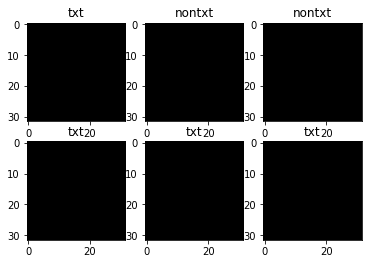

(10, 32, 32, 3) (10,)


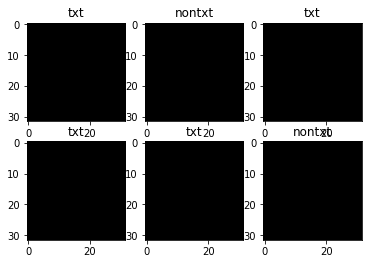

(10, 32, 32, 3) (10,)


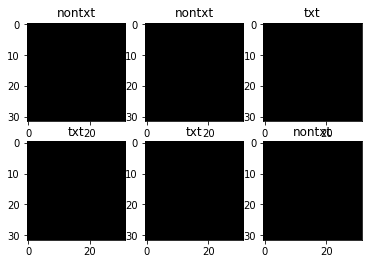

(10, 32, 32, 3) (10,)


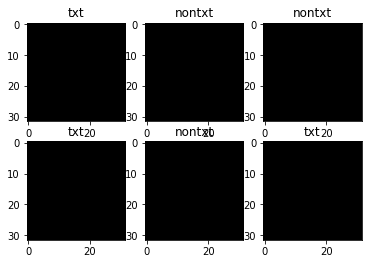

(10, 32, 32, 3) (10,)


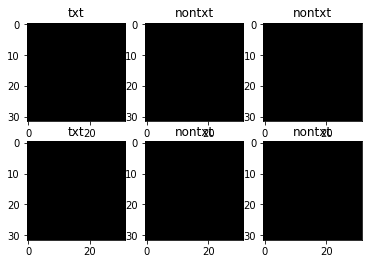

In [7]:
#############It's time for us to read data from TFRecords file############
# import data in the format of tf.
# features and feature 
# be careful with protocol
# debug with whole your heart and whole your goal
# image decode shape. what's the input and format
height   = tf.constant(32, dtype=tf.int32)
width    = tf.constant(32, dtype=tf.int32)
def tfrecord_read(filename, num_epochs, batch_size):
    feature = { 'dataset/label': tf.FixedLenFeature([], tf.int64),
                'dataset/data' : tf.FixedLenFeature([], tf.string)
              }
    # create a queue to hold filenames 
    filename_queue = tf.train.string_input_producer([filename], num_epochs=num_epochs)
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)
    features = tf.parse_single_example(
      serialized_example,
      features = feature)
    # Decode the jpeg
#     with tf.name_scope('decode_jpeg',[image_buffer], None):
#         # decode
#         image = tf.image.decode_jpeg(image_buffer, channels=3)
#         # resize
#         image = tf.image.resize_images(image, [height, width])
#         # convert to single precision data type
#         image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.decode_raw(features['dataset/data'], tf.float32)
    image = tf.reshape(image, [32, 32, 3])
    # Convert from [0, 255] -> [-0.5, 0.5] floats.
    image = tf.cast(image, tf.float32) * (1. / 255) - 0.5
    label = tf.cast(features['dataset/label'], tf.int32)  
    # Creates batches by randomly shuffling tensors
    images, labels = tf.train.shuffle_batch([image, label], batch_size=batch_size, capacity=30, num_threads=1, min_after_dequeue=1)
    #print(images.shape)
    return (images, labels)                               

# a general demo module to test our methods
%matplotlib inline   
filename = 'train.tfrecords'
num_epochs = 1
batch_size = 10
with tf.Session() as sess:
    images, labels =  tfrecord_read(filename, 1, 10)
    ################# debug ################
    ##########log: successfully debug#######
     # Initialize all global and local variables
    init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    sess.run(init_op)
    # Create a coordinator and run all QueueRunner objects
    coord   = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    for batch_index in range(5):
        #run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
        #run_metadata = tf.RunMetadata()
        img, lbl = sess.run([images, labels])
        print(img.shape, lbl.shape)                                   
        img      = img.astype(np.uint8)
        for j in range(6):
            plt.subplot(2, 3, j+1)
            plt.imshow(img[j, ...])
            plt.title('nontxt' if lbl[j]==0 else 'txt')
        plt.show()
    # Stop the threads
    coord.request_stop()
    # Wait for threads to stop
    coord.join(threads)
    sess.close()
# return images, labels
# train_data, train_label = tfrecord_read('train.tfrecords', 1, 100)
# val_data,   val_label   = tfrecord_read('val.tfrecords',   1, 100)                                           
# test_data, test_label   = tfrecord_read('test.tfrecords',  1, 100)
# print(train_data, train_label)

In [ ]:
# Start to define the hyper-parametes we use 
# Finally we got the chance to run our model
# Save our model periodly

In [ ]:
# def train_input_fn(features, labels, batch_size):
#     """An input function for training"""
#     # Convert the inputs to a Dataset.
#     dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))

#     # Shuffle, repeat, and batch the examples.
#     dataset = dataset.shuffle(1000).repeat().batch(batch_size)

#     # Build the Iterator, and return the read end of the pipeline.
#     return dataset.make_one_shot_iterator().get_next()



In [ ]:
# explore ways to iomport data: to import data in an iterative style, while aslo assign data and labels dynamically
######1. Create Dataset object #######
# function for image reading
import cv2
def read_patch_cv2(filename, label):
    image_decoded = cv2.imread(filename, cv2.IMREAD_COLOR)
    print('here I come')
    return image_decoded, label

def _parse_function(filename, label):
    image_string = tf.read_file(filename)#labels are not put here 
    image = tf.image.decode_image(image_string, channels =  3)
    print('Transforming')
    return image, label

def imgs_input_fn(filenames, labels = None):
    # create labels if there is no source
    if labels is None:
        labels = [0]*len(filenames)
    labels = np.array(labels)
    # to avoid 
    if len(labels) == 1:
        np.expand_dims(labels, axis = 1)
    # convert array/list into tensorflow constants
    filenames = tf.constant(filenames)
    labels = tf.constant(labels)
    #abels = tf.cast(labels, tf.float32)
    # apply standard tf function mapping images data to dataset
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(_parse_function)
    return dataset

def read_txt(filepath, prefix):
    filenames = []
    labels= []
    # read from text files 
    with open(filepath, 'r') as f:
        num = 0
        for line in f:
            num +=1 
            line = line.strip()
            if num < 1:
                print('%s'  %(line[:-2]) )
                print(line[-1])
            filenames.append(prefix+line[:-2])
            labels.append(line[-1])
    print(num)
    return filenames, labels
    
#print(filenames)
filepath_train = '/home/dragonx/Documents/text_detect/dataC/COCO-Text-Patch/train.txt'
filepath_val = '/home/dragonx/Documents/text_detect/dataA/COCO-Text-Patch/val.txt'
filenames_train, labels_train = read_txt(filepath_train, './dataC/COCO-Text-Patch/images/')
filenames_val, labels_val = read_txt(filepath_val, './dataA/COCO-Text-Patch/images/')
dataset_train = imgs_input_fn(filenames_train, labels_train)
dataset_val   = imgs_input_fn(filenames_val, labels_val)
######2. batch_read() ####### 
#either from file directory, or by the txt file with filenames  

######3. Create tfRecord Object #######

#(recommended)
######4. Read from npy format(one by one or in total)  #######

In [ ]:
# Data import with Dataset
filenames = tf.placeholder(tf.string, shape=[None])
dataset = tf.data.TFRecordDataset(filenames)
dataset = dataset.map(...)  # Parse the record into tensors.
dataset = dataset.repeat()  # Repeat the input indefinitely.
dataset = dataset.batch(32)
iterator = dataset.make_initializable_iterator()

# You can feed the initializer with the appropriate filenames for the current
# phase of execution, e.g. training vs. validation.

# Initialize `iterator` with training data.
training_filenames = ["train-00000-of-00001"]
train = sess.run(iterator.initializer, feed_dict={filenames: training_filenames})

# Initialize `iterator` with validation data.
# validation_filenames = ["validation-00000-of-00001"]
# val = sess.run(iterator.initializer, feed_dict={filenames: validation_filenames})

In [8]:
# self defined data import as numpy array
# data input into filenames, and randomly choose filenames patch by patch, so each time the 
# data is read from raw data, the time consumes in the 
import os
import cv2
train_dir = './dataC/COCO-Text-Patch/images/'
val_dir =   './dataA/COCO-Text-Patch/images/'
classes = ['txt', 'nontxt']
fname_tr   = []
labels_tr  = []
fname_val  = []
labels_val = []
for i, c in enumerate(classes):
    buffer = os.listdir(train_dir+c)
    buffer = [train_dir+c+'/'+x for x in buffer]
    fname_tr.extend(buffer[:])
    labels_tr.extend([i]*len(buffer))
    # the same for val
    buffer = os.listdir(val_dir+c)
    buffer = [val_dir+c+'/'+x for x in buffer]
    fname_val.extend(buffer[:])
    labels_val.extend([i]*len(buffer))

print(len(fname_tr))
print(len(fname_val))
# print(fname_tr[0:100])
# check if numbers are correct
assert len(fname_tr) == len(labels_tr)
index_tr = np.arange(0, len(labels_tr))  
index_val= np.arange(0, len(labels_val))  
def imread_batch(filenames, labels):
    train_data = np.zeros([len(filenames), 32, 32, 3])
    for i, f in enumerate(filenames):
        #print(f)
        buffer = cv2.imread(f)
        train_data[i, :,:,:] = buffer[:,:,:]
        #print(buffer.shape)
    labels = label_encoder(labels, C, style = 'one_hot_matrix')
    
    return train_data, labels

#data_tr, labels_tr = imread_batch(fname_tr[0:100], labels_tr[0:100])
#data_val,labels_val = imread_batch(fname_val[0:100], labels_val[0:100])
# data_tr, labels_tr = imread_batch(fname_tr(index_tr[0:100]) , labels_tr[0:100])
print(np.take(fname_tr, index_tr[1:10], axis = 0))          

108012
122324
['./dataC/COCO-Text-Patch/images/txt/txt_615639.jpg'
 './dataC/COCO-Text-Patch/images/txt/txt_660131.jpg'
 './dataC/COCO-Text-Patch/images/txt/txt_235518.jpg'
 './dataC/COCO-Text-Patch/images/txt/txt_734094.jpg'
 './dataC/COCO-Text-Patch/images/txt/txt_336638.jpg'
 './dataC/COCO-Text-Patch/images/txt/txt_374506.jpg'
 './dataC/COCO-Text-Patch/images/txt/txt_127162.jpg'
 './dataC/COCO-Text-Patch/images/txt/txt_713484.jpg'
 './dataC/COCO-Text-Patch/images/txt/txt_43367.jpg']


In [8]:
############ for training detail ##############
# x, y_: input labels
# y_conv: convolutional layers output
import time
import os
# training hyperparameters, with specifications on saving models
batch_size    = 100
num_tr        = len(train_addrs)/batch_size
epoch_num     = 10
train_record  = []
global_step   = tf.Variable(10, dtype=tf.int32, trainable=False, name = 'global_step')
dir_summaries = 'running_summary'
Flags_restore = False
saver         = tf.train.Saver()
ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoint'))
if ckpt and ckpt.model_checkpoint_path:
    saver.restore(sess, ckpt.model_checkpoint_path)
with tf.Session() as sess:
    # build model 
    Model = model('ffnet')
    x  = tf.placeholder(tf.float32, shape = [None, 32, 32, 3])
    y  = tf.placeholder(tf.float32, shape = [None, 2]) 
    Model.builder(x, y)
    Model.loss       = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = y, logits = Model.y_))
    Model.optimizer  = tf.train.AdamOptimizer(1e-4).minimize(Model.loss)
    Model.correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(Model.y_, 1))
    Model.accuracy   = tf.reduce_mean(tf.cast(Model.correct_prediction, tf.float32))
    # computational graph for feeding data
    train_images, train_labels =  tfrecord_read('train.tfrecords', epoch_num, batch_size)
    val_images, val_labels     =  tfrecord_read('val.tfrecords', epoch_num, batch_size)
    # summaries for tensorboard, add loss and accuracy summary
    with tf.name_scope("summaries"):
        tf.summary.scalar("loss", Model.loss)
        tf.summary.scalar("accuracy", Model.accuracy)
    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(dir_summaries + '/train',sess.graph)
    val_writer = tf.summary.FileWriter(dir_summaries + '/val')
    # about restore and reusing 
    ckpt = tf.train.get_checkpoint_state(os.path.dirname('./checkpoint/checkpoint'))
    if ckpt and ckpt.model_checkpoint_path and Flags_restore:
        saver.restore(sess, ckpt.model_checkpoint_path)
        print('Loading variables from %s'%(ckpt.model_checkpoint_path)) 
        tf.reset_default_graph()
    else:
         # Initialize all global and local variables
        init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
        sess.run(init_op)
    
    # Create a coordinator and run all QueueRunner objects
    coord   = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    # main loop for tensorflow training 
    for i in range(epoch_num):
        start_time = time.time()
        print('epoch %d'%(i))
        for j in range(np.int64(num_tr)):
            t1 = time.time()
            # get data using shuffled batch reader from tensorflow 
            t_img, t_lbl = sess.run([train_images,train_labels])
            t_lbl        = label_encoder(t_lbl, 2, style = 'one_hot_matrix').T
            v_img, v_lbl = sess.run([val_images, val_labels])
            v_lbl        = label_encoder(v_lbl, 2, style = 'one_hot_matrix').T
            if (i<1) and (j< 2):
                print(t_img.shape)
                print(v_img.shape)
                print('loading time on %d images is %f seconds'%(batch_size, time.time() -t1))   
            # train the network from scratch using GPU, remember, here we use ood
            if (j) % 20 == 0:
                summary, val_accuracy = sess.run([merged, Model.accuracy], feed_dict={x: v_img, y: v_lbl})
                val_writer.add_summary(summary, i*num_tr+j)
                train_record.append(val_accuracy)
                # import pdb;pdb.set_trace()
                print('%d th accuracy on %d images is %f'%(j, batch_size, val_accuracy))
            # validation accuracy
            else: 
                summary, _ = sess.run([merged, Model.optimizer], feed_dict={x: t_img, y: t_lbl})
                train_writer.add_summary(summary, i*num_tr+j)
                print('running training and generating summary')
        # training time evaluation with timer
        # provide checkpoints to save models sequentially
        epoch_check = 2
        if (i+1)%epoch_check == 0:
            # using the savor function
            saver.save(sess, 'checkpoint/model_V0', global_step = tf.convert_to_tensor(epoch_check*num_tr))
#             run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
#             run_metadata = tf.RunMetadata()
#             summary, _ = sess.run([merged, train_step],
#                                   feed_dict=feed_dict(True),
#                                   options=run_options,
#                                   run_metadata=run_metadata)
#             train_writer.add_run_metadata(run_metadata, 'step%05d' % i*num_tr)
#             print('Adding run metadata for', i*num_tr+j)
        # data visualization & model summary  
        # tf.reset_default_graph()
    

32
64
64
64
64
64
Tensor("ffnet1afast_branch1/A/Relu:0", shape=(?, 12, 12, 64), dtype=float32)
Tensor("ffnet1aconv_branch3/A/Relu:0", shape=(?, 12, 12, 64), dtype=float32)
Tensor("concat:0", shape=(?, 12, 12, 128), dtype=float32)
64
64
64
64
Tensor("ffnet2afast_branch1/A/Relu:0", shape=(?, 8, 8, 64), dtype=float32)
Tensor("ffnet2aconv_branch3/A/Relu:0", shape=(?, 8, 8, 64), dtype=float32)
Tensor("concat_1:0", shape=(?, 8, 8, 128), dtype=float32)
epoch 0
(100, 32, 32, 3)
(100, 32, 32, 3)
loading time on 100 images is 0.429462 seconds
0 th accuracy on 100 images is 0.460000
(100, 32, 32, 3)
(100, 32, 32, 3)
loading time on 100 images is 0.339657 seconds
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and

running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
200 th accuracy on 100 images is 0.680000
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summar

running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
400 th accuracy on 100 images is 0.700000
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summar

running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
600 th accuracy on 100 images is 0.710000
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
620 th accuracy on 100 images is 0.740

running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
820 th accuracy on 100 images is 0.790000
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summar

running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
1020 th accuracy on 100 images is 0.670000
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summa

running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
1220 th accuracy on 100 images is 0.820000
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summa

running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
1420 th accuracy on 100 images is 0.740000
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
1440 th accuracy on 100 images is 0.8

running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
20 th accuracy on 100 images is 0.760000
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary

running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
220 th accuracy on 100 images is 0.690000
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summar

running training and generating summary
running training and generating summary
420 th accuracy on 100 images is 0.730000
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
440 th accuracy on 100 images is 0.750000
running training and generating summary
running training and generating summ

running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
640 th accuracy on 100 images is 0.740000
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summar

running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
840 th accuracy on 100 images is 0.760000
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summar

running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
1040 th accuracy on 100 images is 0.750000
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summa

running training and generating summary
running training and generating summary
1240 th accuracy on 100 images is 0.710000
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
1260 th accuracy on 100 images is 0.780000
running training and generating summary
running training and generating su

running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
1460 th accuracy on 100 images is 0.840000
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summa

running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
40 th accuracy on 100 images is 0.740000
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary

running training and generating summary
240 th accuracy on 100 images is 0.770000
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
260 th accuracy on 100 images is 0.760000
running training and generating summary
running training and generating summary
running training and generating summ

running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
460 th accuracy on 100 images is 0.730000
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summar

running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
660 th accuracy on 100 images is 0.730000
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summar

running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
860 th accuracy on 100 images is 0.730000
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summar

running training and generating summary
1060 th accuracy on 100 images is 0.790000
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
1080 th accuracy on 100 images is 0.730000
running training and generating summary
running training and generating summary
running training and generating su

running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
1280 th accuracy on 100 images is 0.820000
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summary
running training and generating summa

OutOfRangeError: RandomShuffleQueue '_10_shuffle_batch_2/random_shuffle_queue' is closed and has insufficient elements (requested 31, current size 1)
	 [[Node: shuffle_batch_2 = QueueDequeueManyV2[component_types=[DT_FLOAT, DT_INT32], timeout_ms=-1, _device="/job:localhost/replica:0/task:0/device:CPU:0"](shuffle_batch_2/random_shuffle_queue, shuffle_batch_2/n)]]

Caused by op 'shuffle_batch_2', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/dragonx/venv3/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/dragonx/venv3/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/dragonx/venv3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/home/dragonx/venv3/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/dragonx/venv3/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/dragonx/venv3/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/dragonx/venv3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/dragonx/venv3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/dragonx/venv3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/dragonx/venv3/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/dragonx/venv3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 281, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/dragonx/venv3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 232, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/dragonx/venv3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 397, in execute_request
    user_expressions, allow_stdin)
  File "/home/dragonx/venv3/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/dragonx/venv3/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/dragonx/venv3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/dragonx/venv3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/dragonx/venv3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-e230a1bd99ca>", line 30, in <module>
    val_images, val_labels     =  tfrecord_read('val.tfrecords', epoch_num, batch_size)
  File "<ipython-input-7-e5f3cd8563f3>", line 34, in tfrecord_read
    images, labels = tf.train.shuffle_batch([image, label], batch_size=batch_size, capacity=30, num_threads=1, min_after_dequeue=1)
  File "/home/dragonx/venv3/lib/python3.5/site-packages/tensorflow/python/training/input.py", line 1225, in shuffle_batch
    name=name)
  File "/home/dragonx/venv3/lib/python3.5/site-packages/tensorflow/python/training/input.py", line 796, in _shuffle_batch
    dequeued = queue.dequeue_many(batch_size, name=name)
  File "/home/dragonx/venv3/lib/python3.5/site-packages/tensorflow/python/ops/data_flow_ops.py", line 464, in dequeue_many
    self._queue_ref, n=n, component_types=self._dtypes, name=name)
  File "/home/dragonx/venv3/lib/python3.5/site-packages/tensorflow/python/ops/gen_data_flow_ops.py", line 2418, in _queue_dequeue_many_v2
    component_types=component_types, timeout_ms=timeout_ms, name=name)
  File "/home/dragonx/venv3/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/dragonx/venv3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/home/dragonx/venv3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

OutOfRangeError (see above for traceback): RandomShuffleQueue '_10_shuffle_batch_2/random_shuffle_queue' is closed and has insufficient elements (requested 31, current size 1)
	 [[Node: shuffle_batch_2 = QueueDequeueManyV2[component_types=[DT_FLOAT, DT_INT32], timeout_ms=-1, _device="/job:localhost/replica:0/task:0/device:CPU:0"](shuffle_batch_2/random_shuffle_queue, shuffle_batch_2/n)]]


In [25]:
import os
ckpt = tf.train.get_checkpoint_state(os.path.dirname('./checkpoint/checkpoint'))
a = 1
if ckpt and ckpt.model_checkpoint_path and a:
    print(1)
    print('Loading variables from %s'%(ckpt.model_checkpoint_path))

1
Loading variables from ./checkpoint/model_V0-3224


In [32]:
sess = tf.Session()
saver = tf.train.import_meta_graph('checkpoint/FFnet_Classify_V0-0.meta')
saver.restore(sess,tf.train.latest_checkpoint('./checkpoint/'))
# saver.restore(sess, 'checkpoint/FFnet_Classify_')
# with tf.Session() as sess:
#     new_saver = tf.train.import_meta_graph('my_test_model-1000.meta')
#     new_saver.restore(sess, tf.train.latest_checkpoint('./'))
# import tensorflow as tf
 
# sess=tf.Session()    
# #First let's load meta graph and restore weights
# saver = tf.train.import_meta_graph('my_test_model-1000.meta')
# saver.restore(sess,tf.train.latest_checkpoint('./'))
 
 
# # Now, let's access and create placeholders variables and
# # create feed-dict to feed new data
 
# graph = tf.get_default_graph()
# w1 = graph.get_tensor_by_name("w1:0")
# w2 = graph.get_tensor_by_name("w2:0")
# feed_dict ={w1:13.0,w2:17.0}
 
# #Now, access the op that you want to run. 
# op_to_restore = graph.get_tensor_by_name("op_to_restore:0")
 
# print sess.run(op_to_restore,feed_dict)

OSError: File checkpoint/FFnet_Classify_V0-0.meta does not exist.